# Import Packages

In [1]:
import numpy as np
import math as math
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from scipy.spatial.distance import cdist

from sklearn import metrics
import random

# Import Functions

In [2]:
import importlib.util
import os

def source_directory(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith(".py"):
            # Define the module name and path
            module_name = filename[:-3]  # Remove the .py extension
            module_path = os.path.join(directory_path, filename)
            
            # Dynamically load the module
            spec = importlib.util.spec_from_file_location(module_name, module_path)
            module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(module)
            
            # Inject all functions and variables into the global namespace
            globals().update({name: getattr(module, name) for name in dir(module) if not name.startswith("__")})

# Example usage
source_directory("../functions")


In [3]:
source_directory("/Users/simondn/Documents/RashomonActiveLearning/Code/functions/Main")
source_directory("/Users/simondn/Documents/RashomonActiveLearning/Code/functions/Prediction")
source_directory("/Users/simondn/Documents/RashomonActiveLearning/Code/functions/Selector")

In [4]:
def RunLearningProcedure(df_Train, df_Test, df_Candidate, 
                         SelectorType, selector_args,
                         ModelType, model_args):

    ### Set Up ###
    ErrorVec = []
    SelectedObservationHistory = []

    ### Algorithm
    for i in range(0, len(df_Candidate)):

        ### Prediction Model ###
        Model = ModelType(**model_args)
        if "Model" in selector_args.keys(): selector_args['Model'] = Model            # NOTE: THIS IS NOT DYNAMIC

        CurrentError = TestErrorFunction(Model, df_Test)
        ErrorVec.append(CurrentError)

        ### Sampling Procedure ###
        QueryObservationIndex = SelectorType(**selector_args)
        QueryObservation = df_Candidate.loc[[QueryObservationIndex]] # or should this be iloc
        SelectedObservationHistory.append(QueryObservationIndex)

        # print("Iteration: ", i, "| QueryIndex: ", QueryObservationIndex, "| Inclusion: ", QueryObservationIndex in df_Candidate.index)
        # print(df_Train)
        # print(df_Candidate)
        # print("---")
        
        ### Update Train and Candidate Sets ###
        df_Train = pd.concat([df_Train, QueryObservation])
        df_Candidate = df_Candidate.drop(QueryObservationIndex)

        ### Update selector_args and model_args ###                                     # NOTE: THIS IS NOT DYNAMIC
        if "df_Train" in model_args.keys(): model_args['df_Train'] = df_Train
        if "df_Train" in selector_args.keys(): selector_args['df_Train'] = df_Train
        if "df_Candidate" in selector_args.keys(): selector_args['df_Candidate'] = df_Candidate            

    return ErrorVec, SelectedObservationHistory

# Data 

In [5]:
# Define file path and column names
datafile = "/Users/simondn/Documents/RashomonActiveLearning/Data/BostonHousing.data"
column_names = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", 
                "PTRATIO", "B", "LSTAT", "Y"]

# Load data into DataFrame
df = pd.read_csv(datafile, header=None, sep='\s+', names=column_names)

# Separate features and target into arrays
dataArray = df.iloc[:, :-1].values   # All columns except the last (features)
dataOutput = df.iloc[:, -1].values   # Only the last column (target)

# Print to check if it loaded correctly
print(df.head())
print("Data array shape:", dataArray.shape)
print("Output array shape:", dataOutput.shape)

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT     Y  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  
Data array shape: (506, 13)
Output array shape: (506,)


# Simulation

## Set Up

In [6]:
### Input ###
SimulationN = 100
seed = 1
TestProportion = 0.2
CandidateProportion = 0.8
alpha = 0.01

### Set Up ###
SimulationErrorResultsPassive = []
SimulationErrorResultsGSx = []
SimulationErrorResultsGSy_Test = []
SimulationErrorResultsGSy = []
SimulationErrorResultsiGS = []
SimulationErrorResultsiGS_Test = []

## Simulation

In [7]:
for seed in range(0,SimulationN):

    print("Simulation iter: ", seed)

    ### Set Seed ###
    random.seed(seed)
    np.random.seed(seed)

    ### Set Up ###
    ErrorVec = []
    SelectedObservationHistory = []

    ### Train Test Candidate Split ###
    df_Train, df_Test, df_Candidate = TrainTestCandidateSplit(df, TestProportion, CandidateProportion)

    ### Learning Algorithm ###

    ## Passive ##
    ErrorVecPassive, SelectedObservationHistoryPassive = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = PassiveLearning, 
                     selector_args = {'df_Candidate' : df_Candidate},
                     ModelType = RidgeRegressionFunction, 
                     model_args = {'df_Train' : df_Train,
                                    'alpha_val': alpha}
                     )
    
    ## GSx ##
    ErrorVecGSx, SelectedObservationHistoryGSx = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = GSxFunction, 
                     selector_args = {'df_Train' : df_Train,
                                      'df_Candidate' : df_Candidate,
                                      'distance' : 'euclidean'},
                     ModelType = RidgeRegressionFunction, 
                     model_args = {'df_Train' : df_Train,
                                    'alpha_val': alpha}
                     )
    
    ## GSy - Training ##
    ErrorVecGSy, SelectedObservationHistoryGSy = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = GSyFunction, 
                     selector_args = {'df_Train' : df_Train,                  #  NOTE: or should this be df_Test
                                      'df_Candidate' : df_Candidate,
                                      'Model': None,
                                      'distance' : 'euclidean'},
                     ModelType = RidgeRegressionFunction, 
                     model_args = {'df_Train' : df_Train,
                                    'alpha_val': alpha}
                     )
    
    ## iGS ##
    ErrorVeciGS, SelectedObservationHistoryiGS = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = iGSFunction, 
                     selector_args = {'df_Train' : df_Train,                  #  NOTE: or should this be df_Test
                                      'df_Candidate' : df_Candidate,
                                      'Model': None,
                                      'distance' : 'euclidean'},
                     ModelType = RidgeRegressionFunction, 
                     model_args = {'df_Train' : df_Train,
                                    'alpha_val': alpha}
                     )

    ## GSy - Test ##
    ErrorVecGSy_Test, SelectedObservationHistoryGSy_Test = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = GSyFunction, 
                     selector_args = {'df_Train' : df_Test,                  #  NOTE: or should this be df_Test
                                      'df_Candidate' : df_Candidate,
                                      'Model': None,
                                      'distance' : 'euclidean'},
                     ModelType = RidgeRegressionFunction, 
                     model_args = {'df_Train' : df_Train,
                                    'alpha_val': alpha}
                     )
    
    ## iGS - Test ##
    ErrorVeciGS_Test, SelectedObservationHistoryiGS_Test = RunLearningProcedure(df_Train = df_Train, 
                     df_Test = df_Test, 
                     df_Candidate = df_Candidate, 
                     SelectorType = iGSFunction, 
                     selector_args = {'df_Train' : df_Test,                  #  NOTE: or should this be df_Test
                                      'df_Candidate' : df_Candidate,
                                      'Model': None,
                                      'distance' : 'euclidean'},
                     ModelType = RidgeRegressionFunction, 
                     model_args = {'df_Train' : df_Train,
                                    'alpha_val': alpha}
                     )
    
    ### Save ###
    SimulationErrorResultsPassive.append(ErrorVecPassive)
    SimulationErrorResultsGSx.append(ErrorVecGSx)
    SimulationErrorResultsGSy.append(ErrorVecGSy)
    SimulationErrorResultsGSy_Test.append(ErrorVecGSy_Test)
    SimulationErrorResultsiGS.append(ErrorVeciGS)
    SimulationErrorResultsiGS_Test.append(ErrorVeciGS_Test)


Simulation iter:  0
Simulation iter:  1
Simulation iter:  2
Simulation iter:  3
Simulation iter:  4
Simulation iter:  5
Simulation iter:  6
Simulation iter:  7
Simulation iter:  8
Simulation iter:  9
Simulation iter:  10
Simulation iter:  11
Simulation iter:  12
Simulation iter:  13
Simulation iter:  14
Simulation iter:  15
Simulation iter:  16
Simulation iter:  17
Simulation iter:  18
Simulation iter:  19
Simulation iter:  20
Simulation iter:  21
Simulation iter:  22
Simulation iter:  23
Simulation iter:  24
Simulation iter:  25
Simulation iter:  26
Simulation iter:  27
Simulation iter:  28
Simulation iter:  29
Simulation iter:  30
Simulation iter:  31
Simulation iter:  32
Simulation iter:  33
Simulation iter:  34
Simulation iter:  35
Simulation iter:  36
Simulation iter:  37
Simulation iter:  38
Simulation iter:  39
Simulation iter:  40
Simulation iter:  41
Simulation iter:  42
Simulation iter:  43
Simulation iter:  44
Simulation iter:  45
Simulation iter:  46
Simulation iter:  47
Si

In [10]:
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/Results/BostonHousing_Ridge_Passive.csv", 
              SimulationErrorResultsPassive, 
              delimiter=",")
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/Results/BostonHousing_Ridge_GSx.csv", 
              SimulationErrorResultsGSx, 
              delimiter=",")
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/Results/BostonHousing_Ridge_GSy.csv", 
              SimulationErrorResultsGSy,
              delimiter=",")
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/Results/BostonHousing_Ridge_iGS.csv", 
              SimulationErrorResultsiGS, 
              delimiter=",")
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/Results/BostonHousing_Ridge_GSy_Test.csv", 
              SimulationErrorResultsGSy_Test, 
              delimiter=",")
np.savetxt("/Users/simondn/Documents/RashomonActiveLearning/Results/BostonHousing_Ridge_iGS_Test.csv", 
              SimulationErrorResultsiGS_Test, 
              delimiter=",")

# Plots

In [11]:
### Means ###
SimulationMean_Passive = np.mean(SimulationErrorResultsPassive, axis =0)
SimulationMean_GSx = np.mean(SimulationErrorResultsGSx, axis =0)
SimulationMean_GSy = np.mean(SimulationErrorResultsGSy, axis =0)
SimulationMean_iGS = np.mean(SimulationErrorResultsiGS, axis =0)
SimulationMean_GSy_Test = np.mean(SimulationErrorResultsGSy_Test, axis =0)
SimulationMean_iGS_Test = np.mean(SimulationErrorResultsiGS_Test, axis =0)

### Standard Errors ###
SimulationStd_Passive = np.std(SimulationErrorResultsPassive, axis=0) / np.sqrt(len(SimulationErrorResultsPassive))
SimulationStd_GSx = np.std(SimulationErrorResultsGSx, axis=0) / np.sqrt(len(SimulationErrorResultsGSx))
SimulationStd_GSy = np.std(SimulationErrorResultsGSy, axis=0) / np.sqrt(len(SimulationErrorResultsGSy))
SimulationStd_iGS = np.std(SimulationErrorResultsiGS, axis=0) / np.sqrt(len(SimulationErrorResultsiGS))
SimulationStd_GS_Test = np.std(SimulationErrorResultsGSy_Test, axis=0) / np.sqrt(len(SimulationErrorResultsGSy_Test))
SimulationStd_iGS_Test = np.std(SimulationErrorResultsiGS_Test, axis=0) / np.sqrt(len(SimulationErrorResultsiGS_Test))

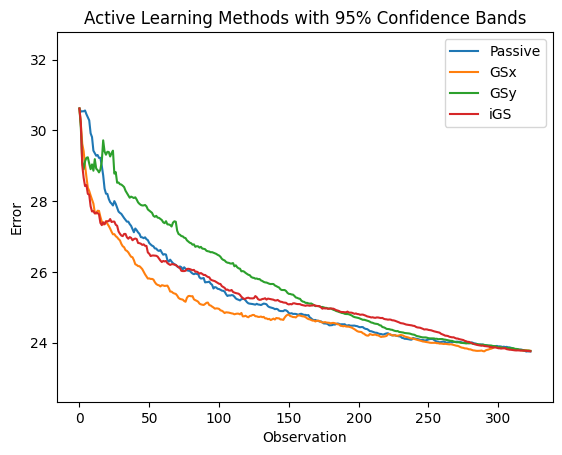

In [14]:
### Plots ###
# Define the x-axis points
ZScore = 1.65
TransparencyVal = 0
XValues = range(len(SimulationMean_Passive))

# Plot each mean line with confidence bands
plt.plot(XValues, SimulationMean_Passive, label="Passive")
plt.fill_between(XValues,
                 SimulationMean_Passive - ZScore * SimulationStd_Passive,
                 SimulationMean_Passive + ZScore * SimulationStd_Passive,
                 color='blue', alpha = TransparencyVal)

plt.plot(XValues, SimulationMean_GSx, label="GSx")
plt.fill_between(XValues,
                 SimulationMean_GSx - ZScore * SimulationStd_GSx,
                 SimulationMean_GSx + ZScore * SimulationStd_GSx,
                 color='orange', alpha = TransparencyVal)

plt.plot(XValues, SimulationMean_GSy, label="GSy")
plt.fill_between(XValues,
                 SimulationMean_GSy - ZScore * SimulationStd_GSy,
                 SimulationMean_GSy + ZScore * SimulationStd_GSy,
                 color='green', alpha = TransparencyVal)

plt.plot(XValues, SimulationMean_iGS, label="iGS")
plt.fill_between(XValues,
                 SimulationMean_iGS - ZScore * SimulationStd_iGS,
                 SimulationMean_iGS + ZScore * SimulationStd_iGS,
                 color='red', alpha = TransparencyVal)

# Add legend and labels
plt.legend()
plt.xlabel("Observation")
plt.ylabel("Error")
plt.title("Active Learning Methods with 95% Confidence Bands")
plt.show()

# Statistical Testing - Dunn's Procedure

In [15]:
### Set Up ###
SimulationResults = pd.DataFrame({"Passive": SimulationMean_Passive,
                                  "GSx": SimulationMean_GSx,
                                  "GSy": SimulationMean_GSy,
                                  "iGS": SimulationMean_iGS,})
SimulationResults_Long = SimulationResults.melt(var_name="Algorithm", value_name="RMSE")


In [16]:
### Results ###
DunnResults = sp.posthoc_dunn(SimulationResults_Long, val_col='RMSE', group_col='Algorithm', p_adjust='fdr_bh')

print(DunnResults<0.05)

           GSx    GSy  Passive    iGS
GSx      False   True     True   True
GSy       True  False     True  False
Passive   True   True    False   True
iGS       True  False     True  False
